In [ ]:
import numpy as np
import tensorflow as tf
import random
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [ ]:
# Caricamento dei dati
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Caricamento dei dati
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=-1, as_supervised=True)
x_train, y_train = tfds.as_numpy(train_ds)
x_test, y_test = tfds.as_numpy(test_ds)
#x_train = x_train[:,:,:,0]
#x_test = x_test[:,:,:,0]

In [ ]:
# Normalizzazione dei pixel a [0, 1]
norm_x_train = x_train.astype('float32') / 255.
norm_x_test = x_test.astype('float32') / 255.

# Dataset Analisys

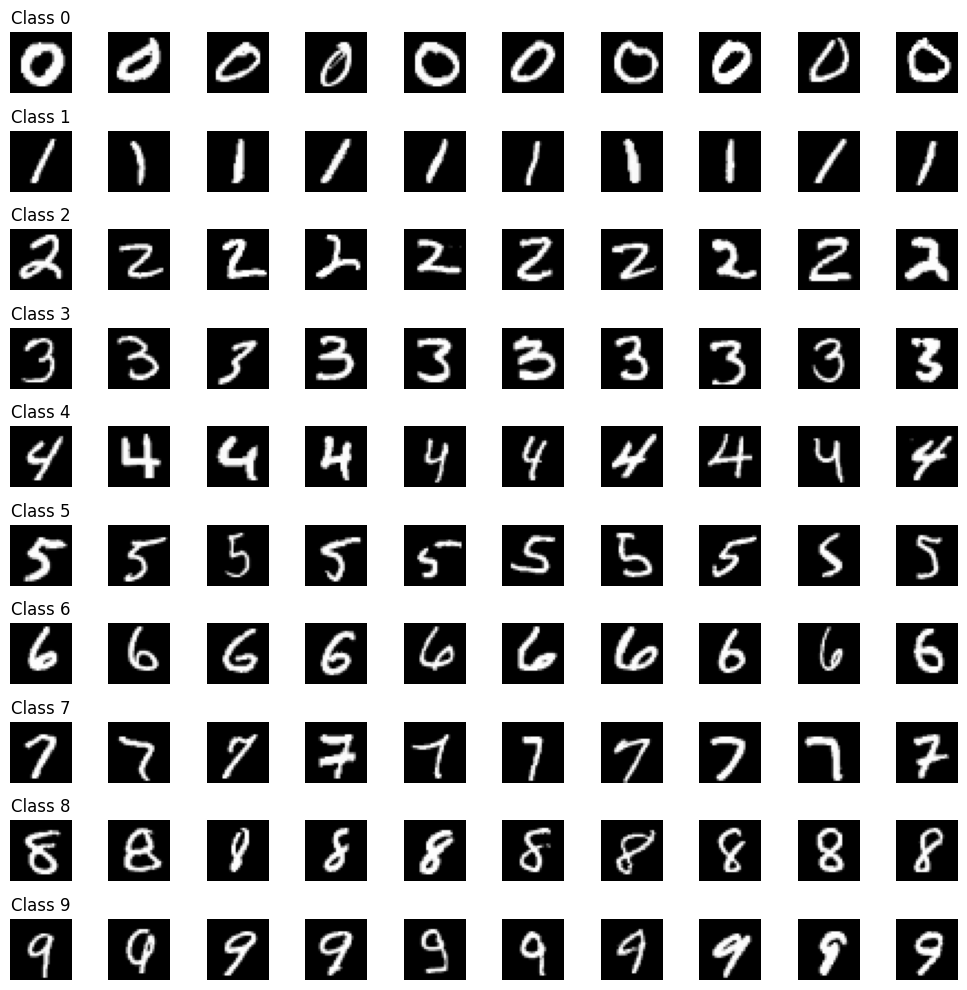

In [ ]:
# Troviamo le classi presenti (da 0 a 9)
classes = np.unique(y_train)
n_classes = len(classes)
samples_per_class = 10  # Numero di esempi per classe da visualizzare

# Creiamo una griglia di subplot: righe = n_classes, colonne = samples_per_class
fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class * 1, n_classes * 1))

for i, cls in enumerate(classes):
    # Trova gli indici degli esempi per la classe corrente
    idxs = np.where(y_train == cls)[0]    
    # Mostra l'etichetta sulla prima colonna di ogni riga
    axes[i, 0].set_title(f"Class {cls}")
    j=0    
    # Seleziona randomicamente samples_per_class indici tra quelli della classe corrente
    for idx in random.sample(list(idxs), samples_per_class):
        # Seleziona l'immagine
        img = x_train[idx]
        # Visualizza l'immagine
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        j=j+1

plt.tight_layout()
plt.show()

# Utils

In [ ]:
# Funzione per il sampling: genera n vettori latenti campionando da una distribuzione
# normale parametrizzata dalle statistiche dei vettori latenti del training set.
def get_2d_sample_from_norm_distr(mean, std, inf_lim, sup_lim):
    """
    Genera n vettori latenti campionando da una distribuzione normale con mean e std
    calcolati dai dati di training.
    """
    return np.random.normal(loc=mean, scale=std, size=(inf_lim, sup_lim))

In [ ]:
# an example of enc_layers_spec = [{'dim': 128, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 32,  'activation': 'relu'}]
# an example of dec_layers_spec = [{'dim':  32, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 128, 'activation': 'relu'}]
def create_autoencoder(input_shape, enc_layers_spec, dec_layers_spec):
    if enc_layers_spec[-1]['dim'] != dec_layers_spec[0]['dim']:
        raise ValueError("Last layer of encoder and first layer of decoder must have the same dimension")

    # Definizione dell'Encoder
    enc_input_layer = Input(shape=input_shape)
    enc_layer = enc_input_layer
    for enc_layer_spec in enc_layers_spec:
        layer_dim = enc_layer_spec['dim']
        activation = enc_layer_spec['activation']
        enc_layer = Dense(layer_dim, activation=activation)(enc_layer)
    # Modello encoder
    encoder = Model(enc_input_layer, enc_layer, name="encoder")

    # Definizione del Decoder
    dec_input_layer = Input(shape=(dec_layers_spec[0]['dim'],))
    dec_layer = dec_input_layer
    for i in range(1,len(dec_layers_spec)):
        dec_layer_spec = dec_layers_spec[i]
        layer_dim = dec_layer_spec['dim']
        activation = dec_layer_spec['activation']
        dec_layer = Dense(layer_dim, activation=activation)(dec_layer)
    dec_layer = Dense(input_shape[0], activation='sigmoid')(dec_layer)
    # Modello decoder
    decoder = Model(dec_input_layer, dec_layer, name="decoder")

    # Definizione dell'autoencoder
    autoencoder_input = enc_input_layer
    autoencoder_output = decoder(encoder(autoencoder_input))
    autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")
    # Compilazione del modello
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder, encoder, decoder

In [ ]:
# an example of enc_layers_spec = [{'dim': 32, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]
# an example of dec_layers_spec = [{'dim': 32, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]
def create_autoencoder_conv(input_shape, enc_layers_spec, dec_layers_spec):
    if enc_layers_spec[-1]['dim'] != dec_layers_spec[0]['dim']:
        raise ValueError("Last layer of encoder and first layer of decoder must have the same dimension")
        
    # Definizione dell'Encoder
    enc_input_layer = Input(shape=input_shape)
    enc_layer = enc_input_layer
    for i in range(0,len(enc_layers_spec)-1):
        enc_layer_spec = enc_layers_spec[i]
        layer_dim = enc_layer_spec['dim']
        activation = enc_layer_spec['activation']
        enc_layer = Conv2D(layer_dim, (3, 3), activation=activation, padding='same')(enc_layer)
        enc_layer = MaxPooling2D((2, 2), padding='same')(enc_layer)
    enc_layer = Flatten()(enc_layer)                                                                                       # Appiattimento: (7*7*64) = 3136
    enc_layer = Dense(enc_layers_spec[-1]['dim'], activation=enc_layers_spec[-1]['activation'])(enc_layer)                 # Latent dimension: 32
    # Modello encoder
    encoder = Model(enc_input_layer, enc_layer, name="encoder_conv")

    # Definizione del Decoder
    dec_input_layer = Input(shape=(dec_layers_spec[0]['dim'],))
    dec_layer = dec_input_layer
    for i in range(1,len(dec_layers_spec)):
        dec_layer_spec = dec_layers_spec[i]
        layer_dim = dec_layer_spec['dim']
        activation = dec_layer_spec['activation']
        if i == 1:
            dec_layer = Dense(7 * 7 * layer_dim, activation=activation)(dec_layer)
            dec_layer = Reshape((7, 7, layer_dim))(dec_layer)
        dec_layer = Conv2D(layer_dim, (3, 3), activation=activation, padding='same')(dec_layer)
        dec_layer = UpSampling2D((2, 2))(dec_layer)
    dec_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_layer)
    # Modello decoder
    decoder = Model(dec_input_layer, dec_layer, name="decoder_conv")

    # Definizione dell'autoencoder
    autoencoder_input = enc_input_layer
    autoencoder_output = decoder(encoder(autoencoder_input))
    autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder_conv")
    # Compilazione del modello
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder, encoder, decoder


In [ ]:
# an example of enc_layers_spec = [{'dim': 32, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]
# an example of dec_layers_spec = [{'dim': 32, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]
def create_autoencoder_denoisy(input_shape, enc_layers_spec, dec_layers_spec):
    if enc_layers_spec[-1]['dim'] != dec_layers_spec[0]['dim']:
        raise ValueError("Last layer of encoder and first layer of decoder must have the same dimension")

    # Definizione dell'Encoder
    enc_input_layer = Input(shape=input_shape)
    enc_layer = enc_input_layer
    for i in range(0,len(enc_layers_spec)):
        enc_layer_spec = enc_layers_spec[i]
        layer_dim = enc_layer_spec['dim']
        activation = enc_layer_spec['activation']
        enc_layer = Conv2D(layer_dim, (3, 3), activation=activation, padding='same')(enc_layer)
        enc_layer = MaxPooling2D((2, 2), padding='same')(enc_layer)
    # Modello encoder
    encoder = enc_layer

    # Definizione del Decoder
    dec_layer = encoder
    for i in range(0,len(dec_layers_spec)):
        dec_layer_spec = dec_layers_spec[i]
        layer_dim = dec_layer_spec['dim']
        activation = dec_layer_spec['activation']
        dec_layer = Conv2D(layer_dim, (3, 3), activation=activation, padding='same')(dec_layer)
        dec_layer = UpSampling2D((2, 2))(dec_layer)
    dec_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_layer)
    # Modello decoder
    decoder = dec_layer

    # Definizione dell'autoencoder
    autoencoder = Model(enc_input_layer, decoder, name="autoencoder_denoisy")
    # Compilazione del modello
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder, encoder, decoder

In [ ]:
def plot_img(immagine, titolo="Sampled Image", figsize=(4,4)):
    """
    Plotta una immagine, convertendola se necessario da vettoriale (784,) a matrice (28,28).

    Parametri:
    - immagine: numpy array rappresentante l'immagine (forma (784,) o (28,28))
    - titolo: titolo da visualizzare sul plot
    """
    # Se l'immagine è un vettore piatto, la rimodelliamo in 28x28
    if immagine.ndim == 1 or (immagine.ndim == 2 and immagine.shape[0] * immagine.shape[1] == 784):
        immagine = immagine.reshape(28, 28)

    plt.figure(figsize=figsize)
    plt.imshow(immagine, cmap='gray')
    plt.title(titolo)
    plt.axis('off')
    plt.show()

In [ ]:
def plot_encoding_tsne(encoder, data, labels, sample_size=None, perplexity=30, random_state=42, title="t-SNE projection of the latent space"):
    """
    Calcola l'encoding dei dati con il modello encoder e proietta le rappresentazioni latenti in 2D
    utilizzando t-SNE. I punti sono colorati in modo discreto in base alle etichette (classi).

    Parametri:
    - encoder: modello Keras per ottenere l'encoding.
    - dati: array dei dati in input (es. immagini).
    - labels: array delle etichette corrispondenti.
    - sample_size: (opzionale) numero di campioni da utilizzare per t-SNE (se None usa tutti i dati).
    - perplexity: parametro perplexity per t-SNE.
    - random_state: seme per la riproducibilità.
    """
    # Se sample_size è definito e minore del numero totale di dati, campiona casualmente
    if sample_size is not None and sample_size < len(data):
        idx = np.random.choice(len(data), size=sample_size, replace=False)
        data = data[idx]
        labels = labels[idx]

    # Calcola l'encoding dei dati
    latent = encoder.predict(data)

    # Riduci a 2 dimensioni con t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    latent_2d = tsne.fit_transform(latent)

    # Ottieni le etichette uniche
    unique_labels = np.unique(labels)
    # Se ci sono al massimo 10 classi, usiamo 'tab10', altrimenti 'tab20'
    if len(unique_labels) <= 10:
        cmap = plt.get_cmap('tab10', len(unique_labels))
    else:
        cmap = plt.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=(8, 6))
    # Plot separato per ogni classe con colori distinti
    for i, ul in enumerate(unique_labels):
        idx = labels == ul
        plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1],
                    color=cmap(i), label=str(ul), s=5)

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title='Classe')
    plt.show()


# Simple Autoencoder

In [ ]:
flatten_x_train = norm_x_train.reshape((len(norm_x_train), -1))
flatten_x_test = norm_x_test.reshape((len(norm_x_test), -1))

input_shape = (flatten_x_train.shape[1],)
enc_layers_spec = [{'dim': 128, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 32,  'activation': 'relu'}]
dec_layers_spec = [{'dim':  32, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 128, 'activation': 'relu'}]

autoencoder, encoder, decoder = create_autoencoder(input_shape, enc_layers_spec, dec_layers_spec)

In [ ]:
history = autoencoder.fit(flatten_x_train, flatten_x_train,
                epochs=10,
                batch_size=512,
                shuffle=True,
                validation_data=(flatten_x_test, flatten_x_test))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4163 - val_loss: 0.2254
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2068 - val_loss: 0.1711
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1665 - val_loss: 0.1483
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1468 - val_loss: 0.1366
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1359 - val_loss: 0.1289
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1279 - val_loss: 0.1234
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1229 - val_loss: 0.1181
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1186 - val_loss: 0.1151
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1159 - val_loss: 0.1129
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1133 - val_loss: 0.1104


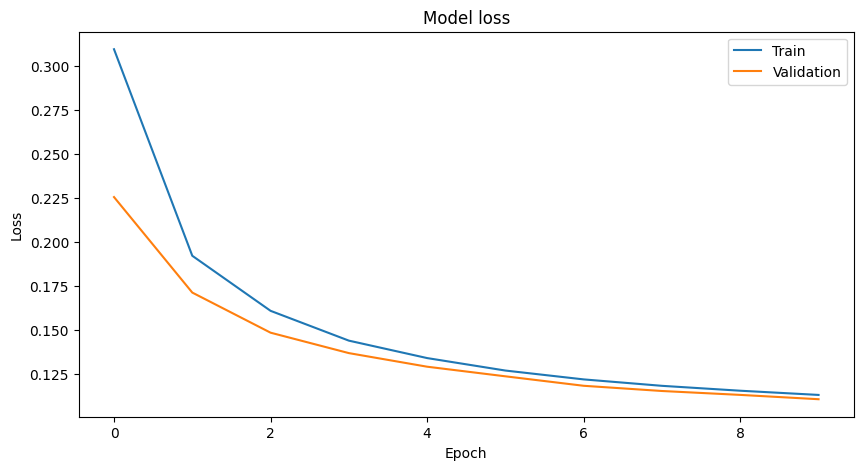

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
latent_reps = encoder.predict(flatten_x_train)
latent_mean = np.mean(latent_reps, axis=0)
latent_std = np.std(latent_reps, axis=0)

#for i in range(0,len(latent_mean)):
#    print(f"{i} | Model >>> Mean: {latent_mean[i]}, Std: {latent_std[i]}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
latent_reps.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


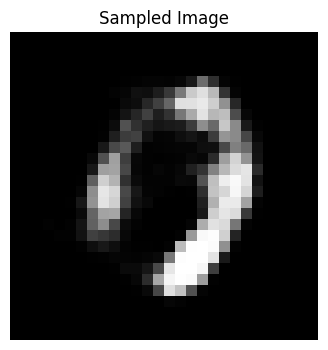

In [ ]:
encoded_img = get_2d_sample_from_norm_distr(latent_mean, latent_std, 1, 32)
# Decodifica per ottenere la ricostruzione
decoded_img = decoder.predict(encoded_img)
# Genera una nuova immagine
plot_img(decoded_img, figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


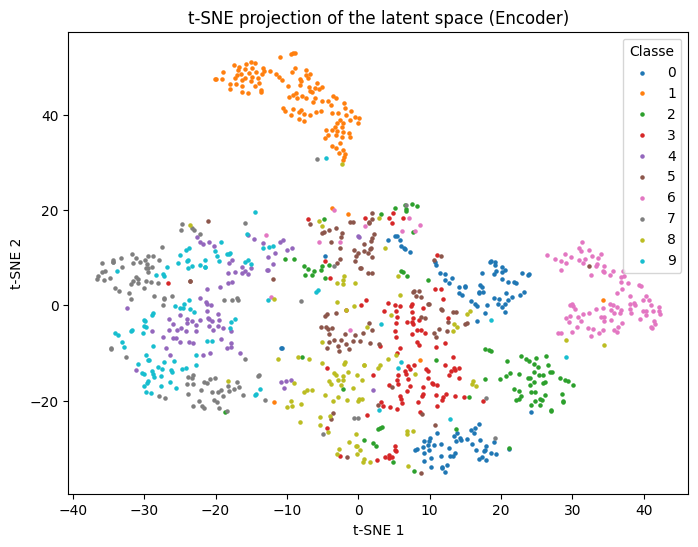

In [ ]:
plot_encoding_tsne(encoder, flatten_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Encoder)")

# Convoluted Autoencoder

In [ ]:
input_shape_conv = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
enc_layers_spec_conv = [{'dim': 32, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]
dec_layers_spec_conv = [{'dim': 32, 'activation': 'relu'}, {'dim': 64, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]

autoencoder_conv, encoder_conv, decoder_conv = create_autoencoder_conv(input_shape_conv, enc_layers_spec_conv, dec_layers_spec_conv)

In [ ]:
tf.config.run_functions_eagerly(True)
history_conv = autoencoder_conv.fit(norm_x_train, norm_x_train,
                epochs=10,
                batch_size=512,
                shuffle=True,
                validation_data=(norm_x_test, norm_x_test))

Epoch 1/10


c:\Workspace\Python\llms-evaluation\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 434ms/step - loss: 0.3478 - val_loss: 0.1741
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 412ms/step - loss: 0.1533 - val_loss: 0.1196
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 433ms/step - loss: 0.1114 - val_loss: 0.1013
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 60s 505ms/step - loss: 0.1006 - val_loss: 0.0938
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 60s 508ms/step - loss: 0.0942 - val_loss: 0.0904
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 499ms/step - loss: 0.0910 - val_loss: 0.0884
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 495ms/step - loss: 0.0887 - val_loss: 0.0859
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 53s 445ms/step - loss: 0.0864 - val_loss: 0.0854
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 490ms/step - loss: 0.0851 - val_loss: 0.0832
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 441ms/step - loss: 0.0837 - val_loss: 0.0821


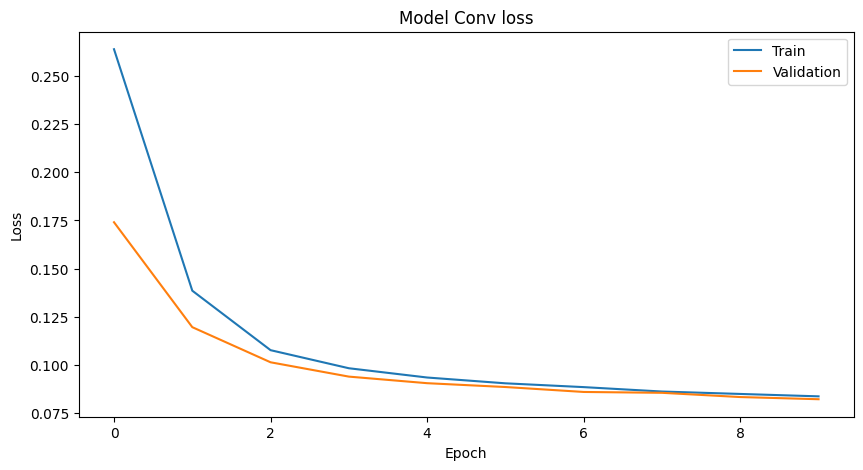

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Model Conv loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
latent_reps_conv = encoder_conv.predict(norm_x_train)
latent_mean_conv = np.mean(latent_reps_conv, axis=0)
latent_std_conv = np.std(latent_reps_conv, axis=0)

#for i in range(0,len(latent_mean_conv)):
#    print(f"{i} | Conv Model >>> Mean: {latent_mean_conv[i]}, Std: {latent_std_conv[i]}")

   6/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step

c:\Workspace\Python\llms-evaluation\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


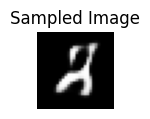

In [ ]:
encoded_img_conv = get_2d_sample_from_norm_distr(latent_mean_conv, latent_std_conv, 1, 32)
# Decodifica per ottenere la ricostruzione
decoded_img_conv = decoder_conv.predict(encoded_img_conv)
# Genera una nuova immagine
plot_img(decoded_img_conv[0], figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


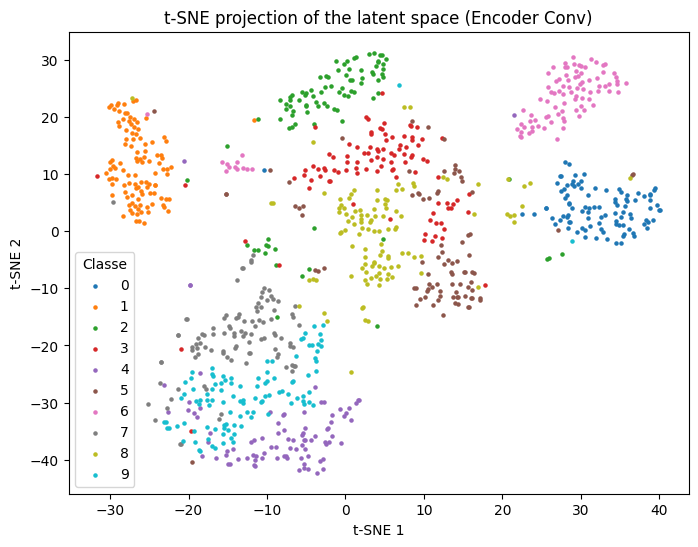

In [ ]:
plot_encoding_tsne(encoder_conv, norm_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Encoder Conv)")

# Denoisy Autoencoder

In [ ]:
input_shape_denoisy = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
enc_layers_spec_denoisy = [{'dim': 32, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]
dec_layers_spec_denoisy = [{'dim': 32, 'activation': 'relu'}, {'dim': 32, 'activation': 'relu'}]

autoencoder_denoisy, encoder_denoisy, decoder_denoisy = create_autoencoder_denoisy(input_shape_denoisy, enc_layers_spec_denoisy, dec_layers_spec_denoisy)

In [ ]:
noisy_x_train = norm_x_train + np.random.normal(loc=0, scale=1, size=norm_x_train.shape)
noisy_x_test = norm_x_test + np.random.normal(loc=0, scale=1, size=norm_x_test.shape)

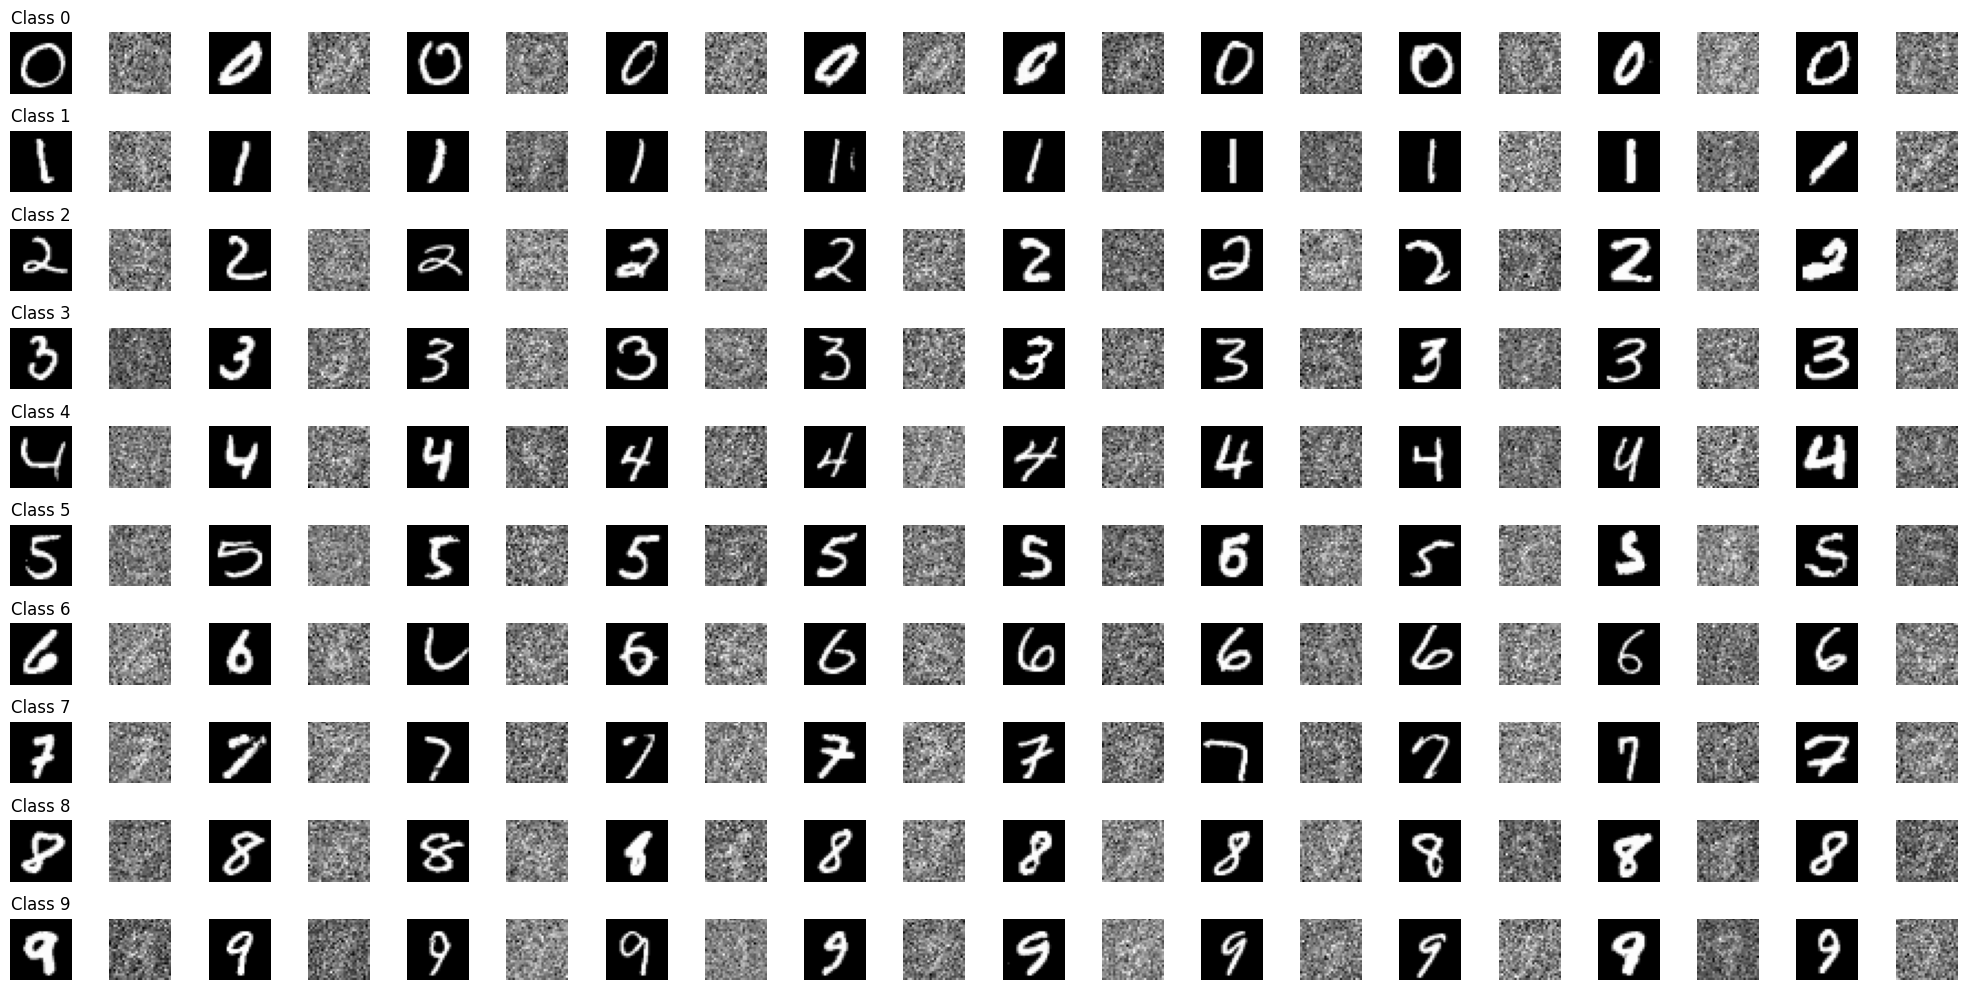

In [ ]:
# Troviamo le classi presenti (da 0 a 9)
classes = np.unique(y_train)
n_classes = len(classes)
samples_per_class = 10  # Numero di esempi per classe da visualizzare

# Creiamo una griglia di subplot: righe = n_classes, colonne = samples_per_class
fig, axes = plt.subplots(n_classes, samples_per_class*2, figsize=(samples_per_class * 2, n_classes * 1))

for i, cls in enumerate(classes):
    # Trova gli indici degli esempi per la classe corrente
    idxs = np.where(y_train == cls)[0]    
    # Mostra l'etichetta sulla prima colonna di ogni riga
    axes[i, 0].set_title(f"Class {cls}")

    j=0    
    # Seleziona randomicamente samples_per_class indici tra quelli della classe corrente
    for idx in random.sample(list(idxs), samples_per_class):
        # Seleziona l'immagine
        img = norm_x_train[idx]
        # Seleziona l'immagine sporca
        noisy_img = noisy_x_train[idx]
        # Visualizza l'immagine
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j+1].imshow(noisy_img, cmap='gray')
        axes[i, j+1].axis('off')
        j=j+2

plt.tight_layout()
plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)
history_denoisy = autoencoder_denoisy.fit(noisy_x_train, norm_x_train,
                epochs=10,
                batch_size=512,
                shuffle=True,
                validation_data=(noisy_x_test, norm_x_test))

c:\Workspace\Python\llms-evaluation\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - loss: 0.3652 - val_loss: 0.1940
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - loss: 0.1887 - val_loss: 0.1761
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - loss: 0.1744 - val_loss: 0.1680
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - loss: 0.1681 - val_loss: 0.1642
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 323ms/step - loss: 0.1643 - val_loss: 0.1611
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - loss: 0.1618 - val_loss: 0.1593
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - loss: 0.1601 - val_loss: 0.1580
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 315ms/step - loss: 0.1590 - val_loss: 0.1568
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 316ms/step - loss: 0.1575 - val_loss: 0.1557
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - loss: 0.1566 - val_loss: 0.1547


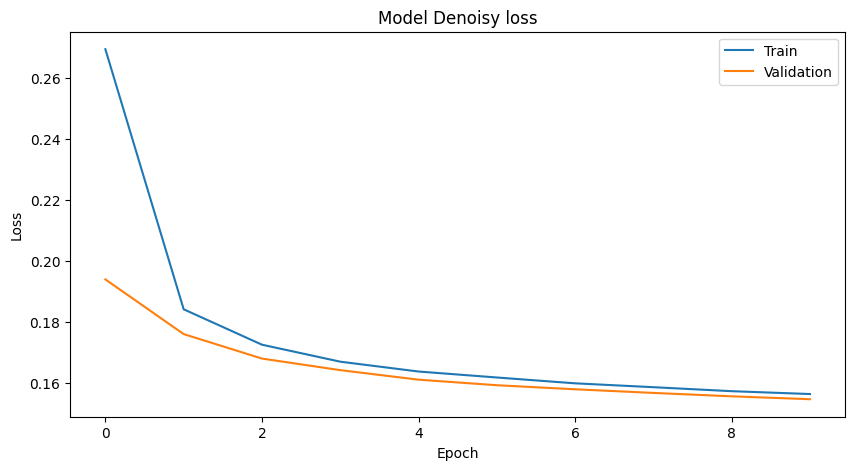

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_denoisy.history['loss'])
plt.plot(history_denoisy.history['val_loss'])
plt.title('Model Denoisy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


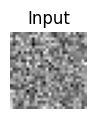

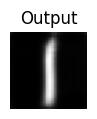

In [ ]:
in_img = np.random.normal(loc=0, scale=1, size=(1, 28, 28, 1))
n_steps = 20
out_img = in_img
for step in range(n_steps):
    # Passa l'immagine corrente attraverso il modello
    out_img = autoencoder_denoisy.predict(out_img)
0
plot_img(in_img[0], titolo="Input", figsize=(1,1))
plot_img(out_img[0], titolo="Output", figsize=(1,1))